In [1]:
import pandas as pd
import numpy as np
import math
import time
from psycopg2.extensions import ISOLATION_LEVEL_AUTOCOMMIT
from psycopg2 import connect
import pandas.io.sql as sqlio
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import plot_decision_regions
import matplotlib.style as style 
import matplotlib.ticker as ticker

%matplotlib inline

# make prettier plots
%config InlineBackend.figure_format = 'svg'

from matplotlib import pyplot
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from numpy import loadtxt
from xgboost import XGBClassifier
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.model_selection import GridSearchCV 
from sklearn import svm
from sklearn.preprocessing import StandardScaler, MinMaxScaler

Using TensorFlow backend.
/Users/saleemkhan/opt/anaconda3/envs/metis/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/saleemkhan/opt/anaconda3/envs/metis/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/saleemkhan/opt/anaconda3/envs/metis/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1

In [2]:
#Let's set up our database connection for our remote AWS instance
params = {
    'host': '3.83.249.10',
    'user': 'postgres',
    'port': 5432
}

# Connect 
connection = connect(**params, dbname='loans')
connection.set_isolation_level(ISOLATION_LEVEL_AUTOCOMMIT)

In [3]:
#I'll be working with one quarter of data as my training and test set
start_time = time.time()
query = """
SELECT * FROM lc_loans_2018;
"""
df = sqlio.read_sql_query(query, connection)
print("--- %s seconds ---" % (time.time() - start_time))

--- 206.90373992919922 seconds ---


# 1. Exploratory Data Analysis

In [4]:
#what's the shape of our data
df.shape

(495242, 150)

In [5]:
#Let's explore the data by looking at the number of loans by their loan status.
loans_by_status = df.groupby(df["loan_status"]).id.count().reset_index()
loans_by_status = loans_by_status.sort_values('id', ascending=False)

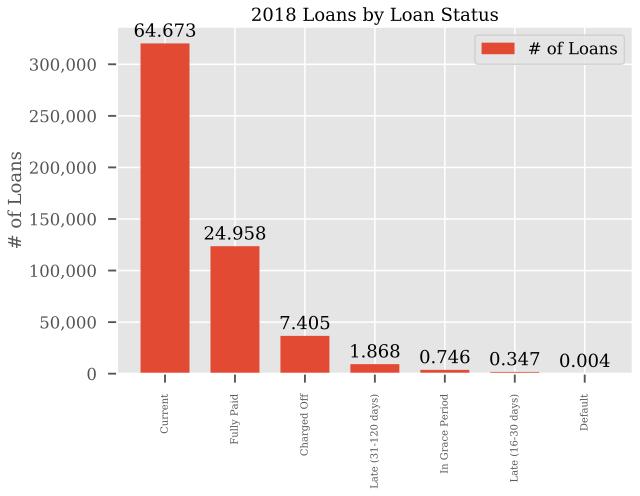

In [75]:
#Let's plot the loans by status and look at their percentage relative to total
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 10}

pyplot.rc('font', **font)
sns.set_context('talk')

x = np.arange(len(loans_by_status["loan_status"]))  # the label locations
width = 0.70  # the width of the bars

fig, ax = plt.subplots(figsize=(9,7))
rects1 = ax.bar(x, loans_by_status["id"], width, label='# of Loans')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('# of Loans')
ax.set_title('2018 Loans by Loan Status')
ax.set_xticks(x)
ax.set_xticklabels(loans_by_status["loan_status"], rotation=90, fontsize=10)
ax.legend()

y_labels = ax.get_yticks()
#ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0e'))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its count & percent."""
    for rect in rects:
        height = rect.get_height()
        percent = round((height/df.shape[0])*100,3)
        ax.annotate('{}'.format(percent),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
style.available
style.use('seaborn-poster') #sets the size of the charts
style.use('ggplot')
fig.tight_layout()
plt.savefig('charts/loans_by_loan_status.png')
plt.show()

In [7]:
#what are the top recurring professions for Lending Club borrowers?
top_recur_jobs = df.groupby("emp_title").id.count().sort_values(ascending=False).head(11)
top_recur_jobs = pd.DataFrame(top_recur_jobs)

#drop the blank job entries
top_recur_jobs.drop(index='')


,id
emp_title,
Teacher,8679
Manager,8008
Owner,5481
Driver,4308
Registered Nurse,3633
Supervisor,3067
RN,2981
Sales,2919
Project Manager,2315


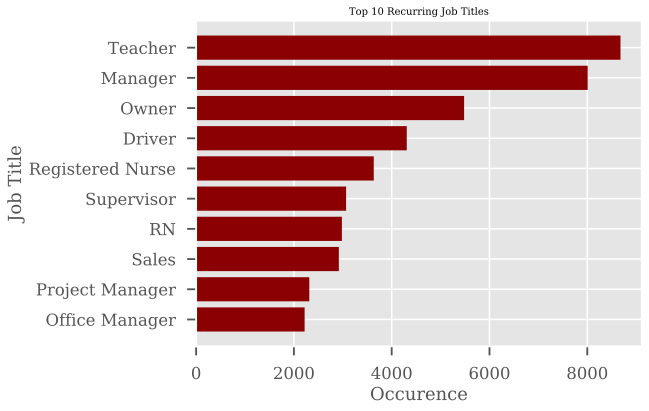

In [8]:
#remove the blank value
emp_data = top_recur_jobs[1:].sort_values(by=['id'])

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 10}

pyplot.rc('font', **font)
sns.set_context('talk')

fig, ax = plt.subplots(figsize=(8,6))
rects1 = ax.barh(emp_data.index, emp_data["id"], color='darkred')
style.available
style.use('seaborn-poster') #sets the size of the charts
style.use('ggplot')
plt.ylabel("Job Title")
plt.xlabel("Occurence")
plt.title("Top 10 Recurring Job Titles", fontsize="10")
plt.savefig('charts/top_recurring_jobs.png')

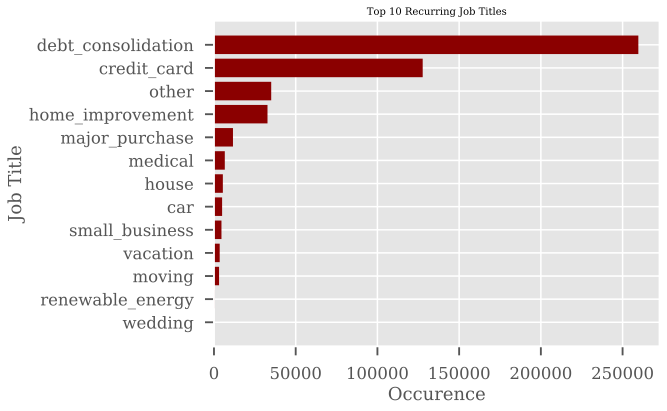

In [9]:
#what are the top recurring professions for Lending Club borrowers?
purpose = df.groupby("purpose").id.count().sort_values(ascending=False)
purpose = pd.DataFrame(purpose)

#remove the blank value
purp_data = purpose.sort_values(by=['id'])

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 10}

pyplot.rc('font', **font)
sns.set_context('talk')

fig, ax = plt.subplots(figsize=(8,6))
rects1 = ax.barh(purp_data.index, purp_data["id"], color='darkred')
style.available
style.use('seaborn-poster') #sets the size of the charts
style.use('ggplot')
plt.ylabel("Job Title")
plt.xlabel("Occurence")
plt.title("Top 10 Recurring Job Titles", fontsize="10")
plt.savefig('charts/top_purposes.png')

In [10]:
#let's split up the loans to compare bad loans to good loans

current_loans_mask = ((df["loan_status"]=="Current"))

good_loans_mask = (df["loan_status"]=="Fully Paid")

questionable_loans_mask = ((df["loan_status"]=='Late (31-120 days)') |
                  (df["loan_status"]=='Late (16-30 days)') |
                  (df["loan_status"]=='In Grace Period'))

bad_loans_mask = ((df["loan_status"]=='Default') |
                  (df["loan_status"]=='Charged Off'))

investment_grade = ((df['grade']=='A') 
                      | (df['grade']=='B')
                      | (df['grade']=='C'))

non_investment_grade = ((df['grade']=='D') 
                      | (df['grade']=='E')
                      | (df['grade']=='F')
                      | (df['grade']=='G'))

In [11]:
#how many good vs. bad loans were there overall?
good_loans = df[good_loans_mask | current_loans_mask | questionable_loans_mask].shape[0]
bad_loans = df[bad_loans_mask].shape[0]
total = good_loans+bad_loans
print("Overall Good Loans: ", good_loans, " - ", round(((good_loans/total)*100),2), "%")
print("Overall Bad Loans : ", bad_loans, "  - ", round(((bad_loans/total)*100),2), "%")

Overall Good Loans:  458551  -  92.59 %
Overall Bad Loans :  36691   -  7.41 %


In [12]:
#Let's remove current loans because they are yet to pay out
good_loans = df[good_loans_mask].shape[0]
bad_loans = df[bad_loans_mask].shape[0]
total = good_loans+bad_loans
print("Good Loans (ex Current): ", good_loans, " - ", round(((good_loans/total)*100),2), "%")
print("Bad Loans (ex Xurrent) : ", bad_loans, "  - ", round(((bad_loans/total)*100),2), "%")

Good Loans (ex Current):  123603  -  77.11 %
Bad Loans (ex Xurrent) :  36691   -  22.89 %


In [13]:
#Let's look at default rates for investment grade loans (i.e. Grade: A,B,C)
good_loans = df[investment_grade & good_loans_mask].shape[0]
bad_loans = df[investment_grade & bad_loans_mask].shape[0]
total = good_loans+bad_loans
print("Investment Grade Good Loans (ex Current): ", good_loans, " - ", round(((good_loans/total)*100),2), "%")
print("Investment Grade Bad Loans (ex Current) : ", bad_loans, "  - ", round(((bad_loans/total)*100),2), "%")

Investment Grade Good Loans (ex Current):  101687  -  81.59 %
Investment Grade Bad Loans (ex Current) :  22948   -  18.41 %


In [14]:
#Let's look at default rates for non-investment grade loans
good_loans = df[non_investment_grade & good_loans_mask].shape[0]
bad_loans = df[non_investment_grade & bad_loans_mask].shape[0]
total = good_loans+bad_loans
print("Non-Investment Grade Good Loans (ex Current): ", good_loans, " - ", round(((good_loans/total)*100),2), "%")
print("Non-Investment Grade Bad Loans (ex Current) : ", bad_loans, "  - ", round(((bad_loans/total)*100),2), "%")

Non-Investment Grade Good Loans (ex Current):  21916  -  61.46 %
Non-Investment Grade Bad Loans (ex Current) :  13743   -  38.54 %


In [15]:
overall = df.groupby("grade").id.count()
bads = df[bad_loans_mask].groupby("grade").id.count()
for i, v in enumerate(overall):
    print((bads[i]/overall[i])*100)

2.3702257040768773
5.636472960067909
9.283405597162002
13.63438866842395
17.844709357527165
23.874015748031496
28.017883755588674


In [16]:
all_loans_emp = df.copy()
all_loans_emp["emp_title"] = df["emp_title"].apply(lambda x: x.lower())
all_loans_emp = all_loans_emp.groupby("emp_title").id.count().sort_values(ascending=False).head(12)

In [17]:
all_loans_emp[1:]

emp_title
teacher             9982
manager             9547
owner               7426
driver              5421
registered nurse    4735
supervisor          3799
sales               3683
rn                  3390
office manager      3017
truck driver        2905
project manager     2780
Name: id, dtype: int64

In [18]:
bad_loans = df[bad_loans_mask]
bad_loans["emp_title"] = bad_loans["emp_title"].apply(lambda x: x.lower())


/Users/saleemkhan/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [19]:
bad_loans = bad_loans.groupby("emp_title").id.count().sort_values(ascending=False).head(11)
bad_loans = pd.DataFrame(bad_loans)

In [20]:
bad_loans[1:]

,id
emp_title,
manager,863
owner,755
teacher,600
driver,574
supervisor,348
sales,334
truck driver,294
registered nurse,276
rn,203


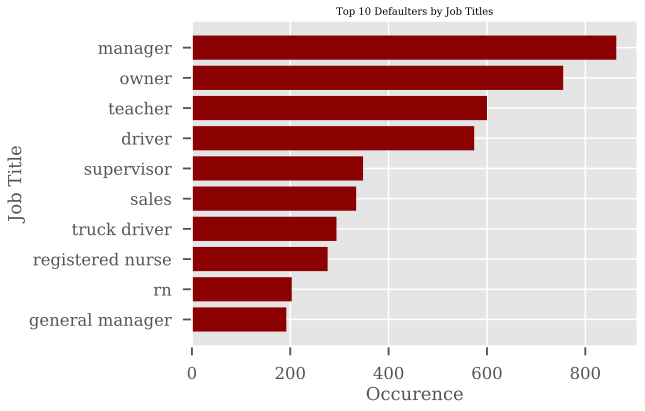

In [21]:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 10}

pyplot.rc('font', **font)
sns.set_context('talk')

bad_loans = bad_loans[1:].sort_values(by=['id'])

fig, ax = plt.subplots(figsize=(8,6))
rects1 = ax.barh(bad_loans.index, bad_loans["id"], color='darkred')
style.available
style.use('seaborn-poster') #sets the size of the charts
style.use('ggplot')
#plt.barh(top_recur_jobs.index, top_recur_jobs["id"], color='green')
plt.ylabel("Job Title")
plt.xlabel("Occurence")
plt.title("Top 10 Defaulters by Job Titles", fontsize="10")
plt.savefig('charts/top_jobs_by_default.png')

In [22]:
#excluding current loans because we don't know whether they will pay out and will only add noise to our model
lc_2018 = df[(  (good_loans_mask) | (bad_loans_mask))]

In [23]:
lc_2018.shape

(160294, 150)

In [24]:
df_copy = lc_2018.copy()

In [25]:
#Now we need to clean up some columns and do some feature engineering

def feature_engineering(df_local):
    #Let's create our dependent variable
    df_local['bad_loan_flag'] = df_local['loan_status'].apply(lambda x: 1 if (x=='Default') | (x=='Charged Off') else 0)
    
    #strip the literal 'months' from the term 
    df_local["term"] = df_local["term"].str.rstrip('months')
    df_local["term"] = df_local["term"].astype('int32')

    #FICO range doesn't need to be a float
    df_local["fico_range_high"] = df_local["fico_range_high"].astype('int32')

    #strip the % from the interest rate and square it to amplify the data point
    df_local["int_rate"] = df_local["int_rate"].str.rstrip('%')
    df_local["int_rate"] = df_local["int_rate"].astype('float64') 
    df_local["int_rate_sqaured"] = df_local["int_rate"].apply(lambda x: math.pow(x,2))

    #take the log of income and loan amount to dampen their effects
    df_local["annual_inc_log"] = df_local["annual_inc"].apply(lambda x: 1 if (x==0) else math.log(x))
    df_local["loan_amnt_log"] = df_local["loan_amnt"].apply(lambda x: 1 if (x==0) else math.log(x))

    #extract the number of years employed
    df_local["emp_length"] = df_local["emp_length"].str.extract(r'(\d*)')
    #there are some blanks in here so we need to fill with -1
    df_local["emp_length"] = df_local["emp_length"].apply(lambda x: -1 if (x=='') else x)
    df_local["emp_length"] = df_local["emp_length"].astype('int32') 

    #debt to income... if DTI is blank i will assign the national average 33%
    df_local["dti"] = df_local["emp_length"].apply(lambda x: 33 if (x=='') else x)
    df_local["dti"] = df_local["dti"].astype('float64') 
    df_local["dti_squared"] = df_local["dti"].apply(lambda x: math.pow(x,2))

    #cast open accounts as int
    df_local["open_acc"] = df_local["open_acc"].astype('int32')

    #revol_util has a % symbol in it.
    df_local["revol_util"] = df_local["revol_util"].apply(lambda x: 10 if (x=='') else x)
    df_local["revol_util"] = df_local["revol_util"].str.rstrip('%')
    df_local["revol_util"] = df_local["revol_util"].astype('float64') 

    #cast average current balance as int
    df_local["avg_cur_bal"] = df_local["avg_cur_bal"].apply(lambda x: -1 if (x=='') else x)
    df_local["avg_cur_bal"] = df_local["avg_cur_bal"].astype('int32')

    #cast bc_open_to_buy
    df_local["bc_open_to_buy"] = df_local["bc_open_to_buy"].apply(lambda x: -1 if (x=='') else x)
    df_local["bc_open_to_buy"] = df_local["bc_open_to_buy"].astype('int32')
    
    return df_local

In [26]:
df_copy = feature_engineering(df_copy)

In [27]:
#what are the top recurring professions for Lending Club borrowers?
int_rate = df_copy.groupby("grade").int_rate.mean().sort_values(ascending=False)
int_rate = pd.DataFrame(int_rate)
print(int_rate)

        int_rate
grade           
G      30.814929
F      29.479927
E      25.224781
D      19.500937
C      14.675486
B      10.857320
A       7.060450


In [28]:
df_copy["bad_loan_flag"].value_counts()

0    123603
1     36691
Name: bad_loan_flag, dtype: int64

In [29]:
df_copy[(df_copy["bad_loan_flag"]==1)].head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,bad_loan_flag,int_rate_sqaured,annual_inc_log,loan_amnt_log,dti_squared
5,131954506,,10000.0,10000.0,10000.0,60,10.90,216.93,B,B4,...,,,,,,1,118.8100,11.373663,9.210340,4.0
8,131652572,,30000.0,30000.0,30000.0,60,19.42,785.17,D,D3,...,,,,,,1,377.1364,11.512925,10.308953,36.0
11,131355244,,24000.0,24000.0,24000.0,60,16.01,583.77,C,C5,...,,,,,,1,256.3201,11.642198,10.085809,100.0
16,131976521,,8000.0,8000.0,8000.0,36,26.77,325.62,E,E5,...,COMPLETE,Jul-2019,1500,17.15,1,1,716.6329,10.126631,8.987197,100.0
22,131628587,,40000.0,40000.0,40000.0,60,24.84,1170.31,E,E3,...,,,,,,1,617.0256,11.498827,10.596635,100.0


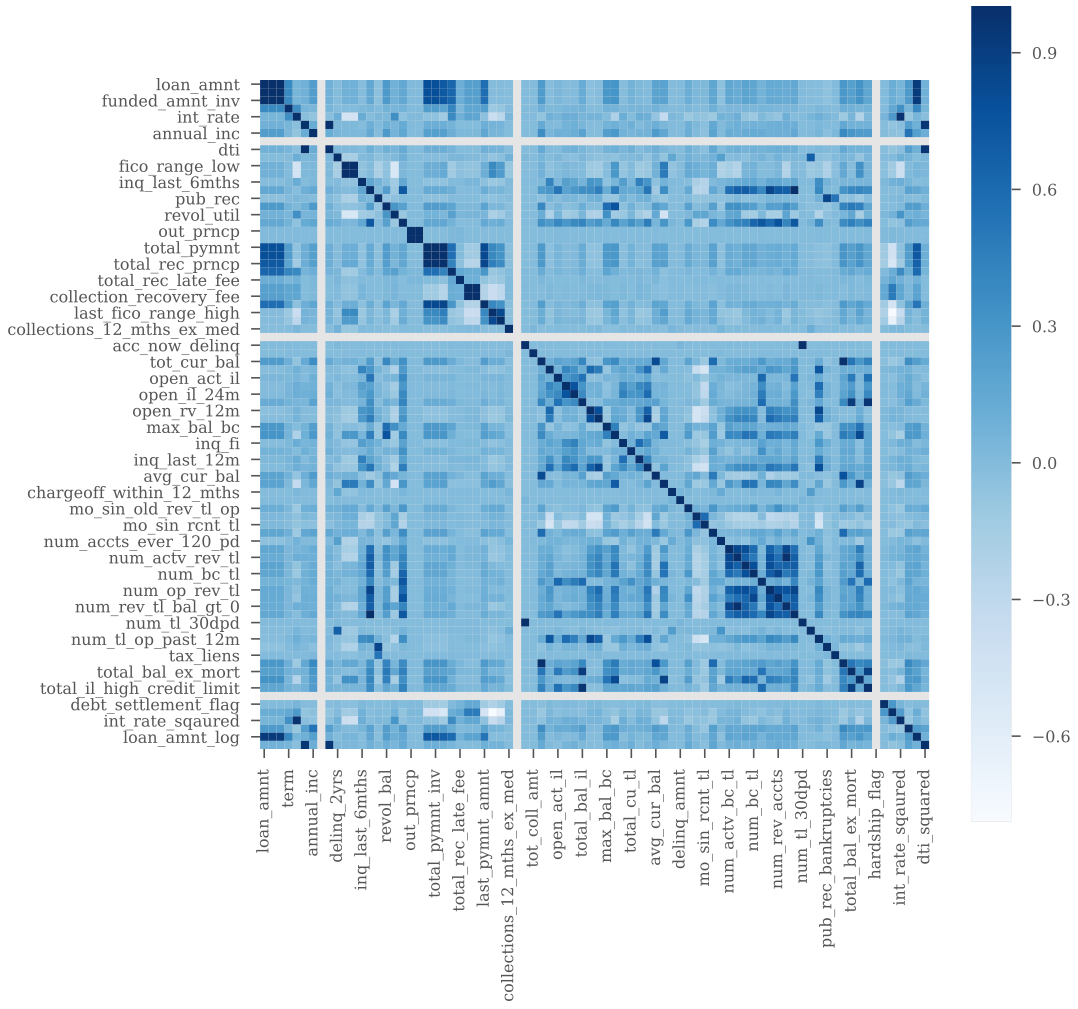

In [30]:
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(df_copy.corr(), square=True, cmap="Blues");
plt.savefig(fname='charts/Correlation_Heatmap.png', dpi=150)

In [31]:
#let's keep 10% as a holdout for later testing
ten_pct=math.ceil((len(df_copy))/10)
print(ten_pct)

df_holdout = feature_engineering(df.sample(n=ten_pct))

16030


In [32]:
#Let's set up our dependent and independent variables
def create_XY(df_local):
    y = df_local["bad_loan_flag"]
    X = df_local[["int_rate", "dti", "annual_inc", "loan_amnt", "fico_range_high", "emp_length"]]

    return X, y

#X = df_copy[["int_rate", "dti", "loan_amnt", "fico_range_high", "emp_length"]]

#X = df_copy[["int_rate", "dti", "loan_amnt", "fico_range_high", "emp_length", "grade", "home_ownership", "verification_status"]]
# X = df_copy[["loan_amnt",
# "home_ownership",
# "annual_inc",
# "verification_status",
# "dti",
# "delinq_2yrs",
# "inq_last_6mths",
# "open_acc",
# "pub_rec",
# "revol_bal",
# #"revol_util",
# "total_acc",
# "collections_12_mths_ex_med",
# "acc_now_delinq",
# "tot_coll_amt",
# "total_rev_hi_lim",
# "acc_open_past_24mths",
# "avg_cur_bal",
# "bc_open_to_buy",
# "chargeoff_within_12_mths",
# "delinq_amnt",
# "mo_sin_old_rev_tl_op",
# "mo_sin_rcnt_rev_tl_op",
# "mo_sin_rcnt_tl",
# "mort_acc",
# "num_accts_ever_120_pd",
# "num_actv_bc_tl",
# "num_actv_rev_tl",
# "num_bc_sats",
# "num_bc_tl",
# "num_il_tl",
# "num_op_rev_tl",
# "num_rev_accts",
# "num_tl_30dpd",
# "num_tl_90g_dpd_24m",
# "num_tl_op_past_12m",
# "pub_rec_bankruptcies",
# "tax_liens",
# "tot_hi_cred_lim",
# "total_bal_ex_mort",
# "total_bc_limit",
# "total_il_high_credit_limit"]]

In [33]:
X,y = create_XY(df_copy)

In [34]:
#significant class imbalance
target_count = y.value_counts()
print(f'Class 0: {target_count[0]}')
print(f'Class 1: {target_count[1]}')
print(f'Proportion: {round(target_count[0] / target_count[1], 2)} : 1')
print(f'Percentage of Majority Class: {round(target_count[0] / sum(target_count), 4)*100}')

Class 0: 123603
Class 1: 36691
Proportion: 3.37 : 1
Percentage of Majority Class: 77.11


# Utility Functions

In [35]:
#prints accuracy metrics for this model
def print_accuracy_scores(model, X_test, y_test):
    model_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, model_pred)
    print(f'Model Accuracy: {round(accuracy, 4)*100}')
    precision = precision_score(y_test, model_pred)
    print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(y_test, model_pred)
    print('Recall: %f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_test, model_pred)
    print('F1 score: %f' % f1)
    auc = roc_auc_score(y_test, model_pred)
    print('ROC AUC: %f' % auc)

In [36]:
#prints accuracy metrics for this model based on predictions
def print_accuracy_scores_on_proba(model_pred, X_test, y_test):
    accuracy = accuracy_score(y_test, model_pred)
    print(f'Model Accuracy: {round(accuracy, 4)*100}')
    precision = precision_score(y_test, model_pred)
    print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(y_test, model_pred)
    print('Recall: %f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_test, model_pred)
    print('F1 score: %f' % f1)
    auc = roc_auc_score(y_test, model_pred)
    print('ROC AUC: %f' % auc)

In [37]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=18):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names, )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

In [38]:
def plot_roc_curve(models, model_names, X_test, y_test):
    font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 12}

    pyplot.rc('font', **font)
    sns.set_context('paper')

    fig, ax = plt.subplots(figsize=(6,6))
    
    for idx, model in enumerate(models):
        probs = model.predict_proba(X_test)
        preds = probs[:,1]
        print(preds)
        fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
        roc_auc = metrics.auc(fpr, tpr)
        ax.plot(fpr, tpr, label = (model_names[idx] + ' AUC = %0.3f' % roc_auc))

    plt.title('ROC Curve')
    ax.legend(loc = 'lower right')
    ax.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    style.available
    style.use('seaborn-poster') #sets the size of the charts
    style.use('ggplot')
    plt.show()


# Model Selection

In [39]:
#pd.get_dummies(X, drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

**Random Forest Baseline**

In [40]:
#Let's start with a basic Random Forest classifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train);

/Users/saleemkhan/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [41]:
print_accuracy_scores(rf, X_test, y_test)

Model Accuracy: 74.99
Precision: 0.384788
Recall: 0.155398
F1 score: 0.221388
ROC AUC: 0.540838


**Gaussian Naive Bayes**

In [42]:
#Create a Gaussian Classifier
gnb = GaussianNB()
#Train the model using the training sets
gnb.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [43]:
print_accuracy_scores(gnb, X_test, y_test)

Model Accuracy: 76.85
Precision: 0.479016
Recall: 0.132770
F1 score: 0.207912
ROC AUC: 0.544961


**K Nearest Neighbors**

In [44]:
#knn
start_time = time.time()
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=14)
knn.fit(X_train_scaled, y_train)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.10535216331481934 seconds ---


In [45]:
print_accuracy_scores(knn, X_test_scaled, y_test)

Model Accuracy: 76.58
Precision: 0.443864
Recall: 0.092694
F1 score: 0.153360
ROC AUC: 0.529116


In [46]:
error = []

# Calculating error for K values between 5 and 15
for i in range(5, 15):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_scaled, y_train)
    pred_i = knn.predict(X_test_scaled)
    error.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Mean Error')

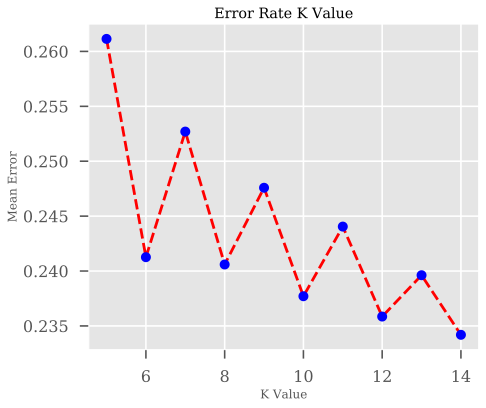

In [47]:
plt.figure(figsize=(7, 6))
plt.plot(range(5, 15), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

**Decision Tree**

In [49]:
# Create Decision Tree classifer object
dtclf = DecisionTreeClassifier()

# Train Decision Tree Classifer
dtclf = dtclf.fit(X_train,y_train)

In [50]:
print_accuracy_scores(dtclf, X_test, y_test)

Model Accuracy: 67.25
Precision: 0.301332
Recall: 0.326881
F1 score: 0.313587
ROC AUC: 0.550996


**Logistic Regression**

In [51]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

/Users/saleemkhan/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [52]:
print_accuracy_scores(logreg, X_test, y_test)

Model Accuracy: 77.23
Precision: 0.514161
Recall: 0.085787
F1 score: 0.147040
ROC AUC: 0.530867


[0.1 0.6 0.4 ... 0.8 0.3 0.6]
[0.11205533 0.23840939 0.20736404 ... 0.2907122  0.2009536  0.27977474]
[0.35714286 0.35714286 0.35714286 ... 0.35714286 0.35714286 0.35714286]
[0. 0. 1. ... 1. 0. 1.]
[0.11932441 0.21259066 0.19657557 ... 0.26386942 0.18845876 0.16600809]


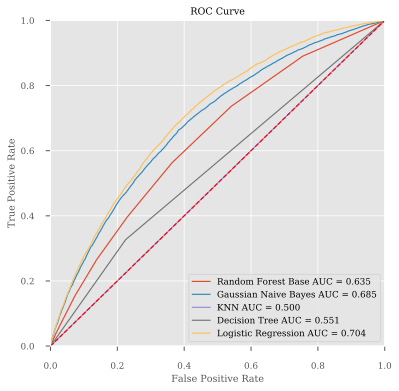

In [53]:
model_list = [rf, gnb, knn, dtclf, logreg]
model_names = ['Random Forest Base', 'Gaussian Naive Bayes', 'KNN', 'Decision Tree', 'Logistic Regression']
plot_roc_curve(model_list, model_names, X_test, y_test)

**Balanced Classes**

In [54]:
#Let's try and balance our classes
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import ADASYN

X_over, y_over = RandomOverSampler(random_state=23).fit_sample(X_train,y_train)
#X_adasyn, y_adasyn = ADASYN(random_state=42).fit_sample(X_train,y_train)

#Random Forest
rf.fit(X_over, y_over);
print("\nRandom Forest Oversampled")
print_accuracy_scores(rf, X_test, y_test)

#Gaussian Naive Bayes
gnb.fit(X_over, y_over);
print("\nGNB Oversampled")
print_accuracy_scores(gnb, X_test, y_test)

#KNN
knn.fit(X_over, y_over);
print("\nKNN")
print_accuracy_scores(knn, X_test, y_test)

#Decision Tree
dtclf.fit(X_over, y_over);
print("\nDecision Tree Oversampled")
print_accuracy_scores(dtclf, X_test, y_test)

#Logistic Regression
logreg.fit(X_over, y_over);
print("\nLog_Reg Oversampled")
print_accuracy_scores(logreg, X_test, y_test)


Random Forest Oversampled
Model Accuracy: 72.57000000000001
Precision: 0.356459
Recall: 0.247001
F1 score: 0.291803
ROC AUC: 0.557342

GNB Oversampled
Model Accuracy: 60.01
Precision: 0.326882
Recall: 0.706016
F1 score: 0.446867
ROC AUC: 0.637314

KNN
Model Accuracy: 60.47
Precision: 0.288701
Recall: 0.496910
F1 score: 0.365215
ROC AUC: 0.566818

Decision Tree Oversampled
Model Accuracy: 67.58999999999999
Precision: 0.293625
Recall: 0.296347
F1 score: 0.294980
ROC AUC: 0.542403


/Users/saleemkhan/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)



Log_Reg Oversampled
Model Accuracy: 65.93
Precision: 0.360110
Recall: 0.629407
F1 score: 0.458114
ROC AUC: 0.648774


**Random Forest Optimized with Random Search**

In [55]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 50, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)


{'n_estimators': [1, 6, 11, 17, 22, 28, 33, 39, 44, 50], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [56]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rfc = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 50, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_over, y_over)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


KeyboardInterrupt: 

In [ ]:
rf_random.best_params_

In [57]:
#Let's start with a basic Random Forest classifier
rf = RandomForestClassifier(n_estimators=6, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', max_depth=None, bootstrap=False)
rf.fit(X_train, y_train);

In [58]:
print_accuracy_scores(rf, X_test, y_test)

Model Accuracy: 73.77
Precision: 0.351017
Recall: 0.172574
F1 score: 0.231388
ROC AUC: 0.538950


**Initial Conclusions**

I had a feeling this might happen. I'm getting very weak ROC/AUC metrics and using Random Forest optimized with Random Search shows no discernable improvement over my base model.

I think i'm going to have to reframe the problem here and see whether loans that are non-investment grade (e.g. grades D, E, F and G) have attributes that are more predictive.

In [59]:
#let's change up our dataset to only look at non-investement grade loans
junk_loans = df[(non_investment_grade & (good_loans_mask) | (bad_loans_mask))]

In [60]:
junk_copy = junk_loans.copy()

In [61]:
junk_copy = feature_engineering(junk_copy)

In [62]:
#let's keep 10% as a holdout for later testing
ten_pct=math.ceil((len(junk_copy))/10)
print(ten_pct)

junk_holdout = feature_engineering(junk_loans.sample(n=ten_pct))

5861


In [63]:
X_junk,y_junk = create_XY(junk_copy)

In [64]:
X_junk_train, X_junk_test, y_junk_train, y_junk_test = train_test_split(X_junk, y_junk, test_size=0.3, random_state=42)
#Let's start with a basic Random Forest classifier
rf_junk = RandomForestClassifier()
rf_junk.fit(X_junk_train, y_junk_train);

/Users/saleemkhan/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [65]:
print_accuracy_scores(rf_junk, X_junk_test, y_junk_test)

Model Accuracy: 74.69
Precision: 0.835616
Recall: 0.737430
F1 score: 0.783459
ROC AUC: 0.749868


Finally! We see a significant improvement in our ROC AUC metric.

[1.  1.  0.5 ... 0.5 1.  1. ]


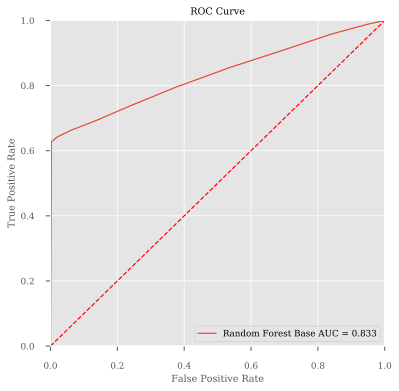

In [66]:
model_list = [rf_junk]
model_names = ['Random Forest Base']
plot_roc_curve(model_list, model_names, X_junk_test, y_junk_test)

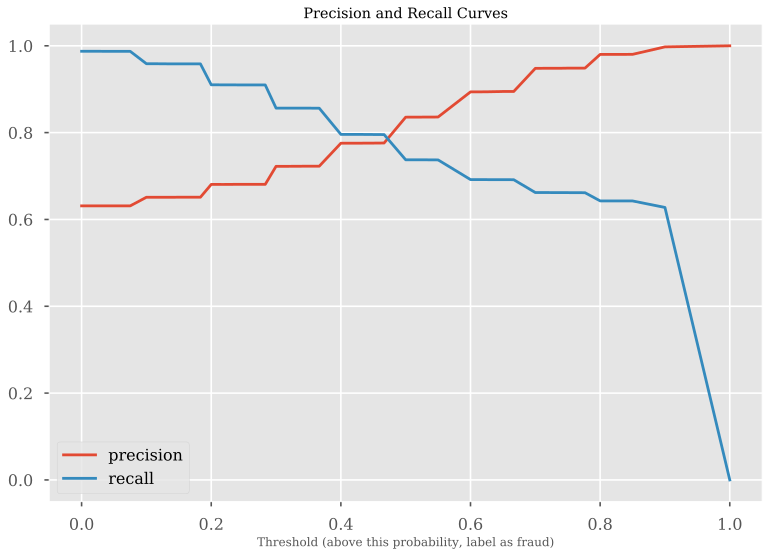

In [67]:
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score

precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_junk_test, rf_junk.predict_proba(X_junk_test)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as fraud)');
plt.title('Precision and Recall Curves');

In [68]:
#print the feature importance
import numpy
feature_list = list(X_junk_test.columns)

# Get numerical feature importances
importances = list(rf_junk.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: int_rate             Importance: 0.48
Variable: annual_inc           Importance: 0.2
Variable: loan_amnt            Importance: 0.15
Variable: fico_range_high      Importance: 0.12
Variable: dti                  Importance: 0.03
Variable: emp_length           Importance: 0.03


# Portfolio Modeling Functions

**Lending Club doesn't provide the total return so i'll need to calculate it.**

Total Return (or Loan Total) = \\(\huge\frac{r * p * n}{1-(1+r)^{-n}} \\)

r = Monthly Interest Rate \
p = Principal \
n = Number of Payments

In [69]:
def calculate_loan_return(loan):
    amnt = loan["loan_amnt"]
    rate = loan["int_rate"]
    term = loan["term"]
    
#     print("Amount: ", amnt)
#     print("Rate: ", rate)
#     print("Term: ", term)
    
    r = (rate/100)/12
    total_loan = (r*amnt*term)/(1-np.power((1+r), -term))
    #print("Total Return: ", total_loan)
    
    return total_loan    

In [70]:
#randomly get n number of loans to create a portfolio
def generate_modeled_loan_portfolio(num_of_loans, model, df):
    df_modeled=pd.DataFrame(columns=df.columns.values)
    while len(df_modeled) < num_of_loans:
        curr_df=df.sample(n=1)
        df_local=curr_df[["int_rate", "dti", "annual_inc", "loan_amnt", "fico_range_high", "emp_length"]]
        if(model.predict(df_local) == 0):
            df_modeled = df_modeled.append(curr_df)        
    return pd.DataFrame(df_modeled)

In [71]:
#simulate a random and modeled portfolio and return the total returns
def simulate_portfolio(num_of_sims, num_of_loans, df_holdout, model):
    #let's calculate the total return for the loan portfolio
    principal = []
    actual_return = []
    actual_return_expected = []
    modeled_actual_return = []
    modeled_return_expected = []

    #Generate our random loan portfolio
    for i in range(num_of_sims):
        df_holdout_sample = df_holdout.sample(n=num_of_loans)
        portfolio_principal = 0
        portfolio_expected_return = 0
        portfolio_actual_return = 0
        for index, loan in df_holdout_sample.iterrows():
            if loan["loan_status"] != "Fully Paid":
                portfolio_principal += loan["loan_amnt"]
                portfolio_actual_return += loan["total_pymnt_inv"]
                portfolio_actual_return += loan["recoveries"]
                portfolio_expected_return += calculate_loan_return(loan)
            else:
                portfolio_principal += loan["loan_amnt"]
                portfolio_expected_return += calculate_loan_return(loan)
                portfolio_actual_return += calculate_loan_return(loan)
        actual_return.append((portfolio_actual_return-portfolio_principal)/portfolio_principal)
        actual_return_expected.append((portfolio_expected_return-portfolio_principal)/portfolio_principal)

    #Generate our modeled loan portfolio
    for x in range(num_of_sims):
        portfolio_principal = 0
        portfolio_expected_return = 0
        portfolio_actual_return = 0
        for index, loan in generate_modeled_loan_portfolio(num_of_loans, model, df_holdout).iterrows():
            if loan["loan_status"] != "Fully Paid":
                portfolio_principal += loan["loan_amnt"]
                portfolio_actual_return += loan["total_pymnt_inv"]
                portfolio_actual_return += loan["recoveries"]
                portfolio_expected_return += calculate_loan_return(loan)
            else:
                portfolio_principal += loan["loan_amnt"]
                portfolio_expected_return += calculate_loan_return(loan)
                portfolio_actual_return += calculate_loan_return(loan)
        modeled_actual_return.append((portfolio_actual_return-portfolio_principal)/portfolio_principal)
        modeled_return_expected.append((portfolio_expected_return-portfolio_principal)/portfolio_principal)

    return actual_return, modeled_actual_return, actual_return_expected, modeled_return_expected

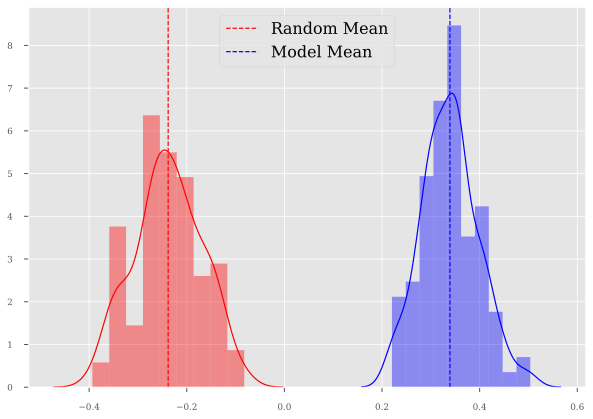

In [74]:
#This take a few minutes to run with 100 simulations of a 100 loan portfolio
actual, modeled, ac_exp, mod_exp = simulate_portfolio(100, 100, junk_holdout, rf_junk)
#actual, modeled, ac_exp, mod_exp = simulate_portfolio(10, 10, junk_holdout, rf_junk)

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 10}

pyplot.rc('font', **font)
sns.set_context('paper')


from statistics import mean
mean_random = mean(actual)
mean_modeled = mean(modeled)
fig, ax = plt.subplots(figsize=(10,7))
ax = sns.distplot(actual, color='r')
ax = sns.distplot(modeled, color='b')
ax.axvline(mean_random, color='r', linestyle='--')
ax.axvline(mean_modeled, color='b', linestyle='--')
style.available
style.use('seaborn-poster') #sets the size of the charts
style.use('ggplot')
plt.legend({'Random Mean':mean_random, 'Model Mean':mean_modeled})
plt.savefig('charts/modeled_portfolio.png')